In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error 

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor as tree
from sklearn.neighbors import KNeighborsRegressor as knn
from xgboost import XGBRegressor

**Outlinet:**

 - Set up
   - Describe dataset
   - Features
   - Add info about features
   - Models used
 - Cross validation wrt to paper
   - Used features
   - Basic results
   - With poly features
 - General ML approach
   - Basic results
   - Results with poly
 - PCA
   - Basic results
   - Results with poly

# Load and Clean Datasets

In [2]:
Hernandes = pd.read_csv('/home/v_trofinov/skoltech_courses/scm/project/project_data/Hernandes.csv', sep=';', decimal=',')
Jung = pd.read_csv('/home/v_trofinov/skoltech_courses/scm/project/project_data/Jung.csv', sep=';', decimal=',')
Lopes = pd.read_csv('/home/v_trofinov/skoltech_courses/scm/project/project_data/Lopes.csv', sep=';', decimal=',')
Zhang = pd.read_csv('/home/v_trofinov/skoltech_courses/scm/project/project_data/Zhang.csv', sep=';', decimal=',')

In [3]:
# Add experiment type
Hernandes['paper'] = 'h'
Jung['paper'] = 'j'
Lopes['paper'] = 'l'
Zhang['paper'] = 'z'

## Rename Columns

Since all the units are the same, lets name columns more convenient.

In [4]:
Hernandes.rename(columns=lambda x: x.split(' (')[0].replace(' ', '_'), inplace=True)
Lopes.rename(columns=lambda x: x.split(' (')[0].replace(' ', '_'), inplace=True)
Jung.rename(columns=lambda x: x.split(' (')[0].replace(' ', '_'), inplace=True)
Zhang.rename(columns=lambda x: x.split(' (')[0].replace(' ', '_'), inplace=True)

## Deal with NaN's

### Hernandes

In [5]:
print(Hernandes.shape)
Hernandes.isna().sum()

(1010, 13)


Shear_Rate                   0
Viscosity                    0
Molecular_Weight             0
Degree_of_Hydrolysis         0
Polymer_Concentration        0
Temperature                  0
Salinity                     0
Ionic_Strength               0
NaCl_conc                    0
NaCl_ionic_strength          0
Salt_mix_conc              353
Salt_mix_ionic_strength    353
paper                        0
dtype: int64

In [6]:
Hernandes['NaCl_only'] = Hernandes[['Salt_mix_conc', 'Salt_mix_ionic_strength']].apply(lambda x: 'yes' if (x[0] == np.nan) & (x[1] == np.nan) else 'no', axis=1)
Hernandes.drop(columns=['Salt_mix_conc', 'Salt_mix_ionic_strength'], inplace=True)

In [7]:
Hernandes.isna().sum()

Shear_Rate               0
Viscosity                0
Molecular_Weight         0
Degree_of_Hydrolysis     0
Polymer_Concentration    0
Temperature              0
Salinity                 0
Ionic_Strength           0
NaCl_conc                0
NaCl_ionic_strength      0
paper                    0
NaCl_only                0
dtype: int64

### Jung

In [8]:
print(Jung.shape)
Jung.isna().sum()

(147, 13)


Shear_Rate                   0
Viscosity                    0
Molecular_Weight             0
Degree_of_Hydrolysis         0
Polymer_Concentration        0
Temperature                  0
Salinity                   147
Ionic_Strength             147
NaCl_conc                   60
NaCl_ionic_strength        147
Salt_mix_conc              147
Salt_mix_ionic_strength    147
paper                        0
dtype: int64

In [9]:
Jung['Salinity'] = Jung['NaCl_conc'].apply(lambda x: 0 if str(x) == 'nan' else x)
Jung['NaCl_only'] = Jung['NaCl_conc'].apply(lambda x: 'no_salt' if str(x) == 'nan' else 'yes')
Jung.drop(columns=['Salt_mix_conc', 'Ionic_Strength', 'Salt_mix_ionic_strength', 'NaCl_conc', 'NaCl_ionic_strength'], inplace=True)

In [10]:
Jung.isna().sum()

Shear_Rate               0
Viscosity                0
Molecular_Weight         0
Degree_of_Hydrolysis     0
Polymer_Concentration    0
Temperature              0
Salinity                 0
paper                    0
NaCl_only                0
dtype: int64

### Lopes

In [11]:
print(Lopes.shape)
Lopes.isna().sum()

(350, 13)


Shear_Rate                   0
Viscosity                    0
Molecular_Weight             0
Degree_of_Hydrolysis       350
Polymer_Concentration        0
Temperature                 16
Salinity                   350
Ionic_Strength             350
NaCl_conc                  334
NaCl_ionic_strength        334
Salt_mix_conc              350
Salt_mix_ionic_strength    350
paper                        0
dtype: int64

In [12]:
Lopes['NaCl_only'] = Lopes['NaCl_conc'].apply(lambda x: 'no_salt' if str(x) == 'nan' else 'yes')
Lopes['Salinity'] = Lopes['NaCl_conc'].apply(lambda x: 0 if str(x) == 'nan' else x)
Lopes['Ionic_Strength'] = Lopes['Ionic_Strength'].apply(lambda x: 0 if str(x) == 'nan' else x)

Lopes.drop(Lopes[Lopes['Temperature'] != 296.15].index, inplace=True)
Lopes.drop(columns=['Degree_of_Hydrolysis', 'NaCl_conc', 'NaCl_ionic_strength', 'Salt_mix_conc', 'Salt_mix_ionic_strength'], inplace=True)

In [13]:
Lopes.isna().sum()

Shear_Rate               0
Viscosity                0
Molecular_Weight         0
Polymer_Concentration    0
Temperature              0
Salinity                 0
Ionic_Strength           0
paper                    0
NaCl_only                0
dtype: int64

### Zhang

In [14]:
print(Zhang.shape)
Zhang.isna().sum()

(406, 12)


Shear_Rate                   0
Viscosity                    0
Molecular_Weight             0
Degree_of_Hydrolysis       406
Polymer_Concentration        0
Temperature                  0
Salinity                     0
NaCl_conc                  406
NaCl_ionic_strength        406
Salt_mix_conc              406
Salt_mix_ionic_strength    406
paper                        0
dtype: int64

In [15]:
Zhang['NaCl_only'] = 'no_salt'
Zhang.drop(columns=['Degree_of_Hydrolysis', 'NaCl_conc', 'NaCl_ionic_strength', 'Salt_mix_conc', 'Salt_mix_ionic_strength'], inplace=True)

In [16]:
Zhang.isna().sum()

Shear_Rate               0
Viscosity                0
Molecular_Weight         0
Polymer_Concentration    0
Temperature              0
Salinity                 0
paper                    0
NaCl_only                0
dtype: int64

## See Data Types

### Hernandes

In [17]:
print(f'Shape = {Hernandes.shape}', end='\n\n')
display(Hernandes.dtypes)
Hernandes.head(2)

Shape = (1010, 12)



Shear_Rate               float64
Viscosity                float64
Molecular_Weight           int64
Degree_of_Hydrolysis     float64
Polymer_Concentration      int64
Temperature              float64
Salinity                 float64
Ionic_Strength           float64
NaCl_conc                float64
NaCl_ionic_strength      float64
paper                     object
NaCl_only                 object
dtype: object

,Shear_Rate,Viscosity,Molecular_Weight,Degree_of_Hydrolysis,Polymer_Concentration,Temperature,Salinity,Ionic_Strength,NaCl_conc,NaCl_ionic_strength,paper,NaCl_only
0,3.00715,0.001305,5000000,0.3,100,298.15,7.8026,0.1373,5.4932,0.094,h,no
1,4.89013,0.001187,5000000,0.3,100,298.15,7.8026,0.1373,5.4932,0.094,h,no


### Jung

In [18]:
print(f'Shape = {Jung.shape}', end='\n\n')
display(Jung.dtypes)
Jung.head(2)

Shape = (147, 9)



Shear_Rate               float64
Viscosity                float64
Molecular_Weight           int64
Degree_of_Hydrolysis     float64
Polymer_Concentration      int64
Temperature              float64
Salinity                 float64
paper                     object
NaCl_only                 object
dtype: object

,Shear_Rate,Viscosity,Molecular_Weight,Degree_of_Hydrolysis,Polymer_Concentration,Temperature,Salinity,paper,NaCl_only
0,1.703218,0.011721,13000000,0.12,1500,298.15,3.0,j,yes
1,2.299130,0.011201,13000000,0.12,1500,298.15,3.0,j,yes


### Lopes

In [19]:
print(f'Shape = {Lopes.shape}', end='\n\n')
display(Lopes.dtypes)
Lopes.head(2)

Shape = (334, 9)



Shear_Rate               float64
Viscosity                float64
Molecular_Weight           int64
Polymer_Concentration    float64
Temperature              float64
Salinity                 float64
Ionic_Strength             int64
paper                     object
NaCl_only                 object
dtype: object

,Shear_Rate,Viscosity,Molecular_Weight,Polymer_Concentration,Temperature,Salinity,Ionic_Strength,paper,NaCl_only
0,0.100794,10.000000,9000000,5000.0,296.15,0.0,0,l,no_salt
1,0.162040,8.141685,9000000,5000.0,296.15,0.0,0,l,no_salt


### Zhang

In [20]:
print(f'Shape = {Zhang.shape}', end='\n\n')
display(Zhang.dtypes)
Zhang.head(2)

Shape = (406, 8)



Shear_Rate                object
Viscosity                 object
Molecular_Weight           int64
Polymer_Concentration      int64
Temperature              float64
Salinity                   int64
paper                     object
NaCl_only                 object
dtype: object

,Shear_Rate,Viscosity,Molecular_Weight,Polymer_Concentration,Temperature,Salinity,paper,NaCl_only
0,5.80731,0.05682,23000000,600,298.15,500,z,no_salt
1,7.56627,0.04749,23000000,600,298.15,500,z,no_salt


In [21]:
Zhang[['Viscosity']] = Zhang[['Viscosity']].astype('float')
Zhang[['Shear_Rate']] = Zhang[['Shear_Rate']].astype('float')

In [22]:
print(f'Shape = {Zhang.shape}', end='\n\n')
display(Zhang.dtypes)
Zhang.head(2)

Shape = (406, 8)



Shear_Rate               float64
Viscosity                float64
Molecular_Weight           int64
Polymer_Concentration      int64
Temperature              float64
Salinity                   int64
paper                     object
NaCl_only                 object
dtype: object

,Shear_Rate,Viscosity,Molecular_Weight,Polymer_Concentration,Temperature,Salinity,paper,NaCl_only
0,5.80731,0.05682,23000000,600,298.15,500,z,no_salt
1,7.56627,0.04749,23000000,600,298.15,500,z,no_salt


## Explore the Data

Let's see what features are in different papers and explore feature values.

In [23]:
plt.rcParams['figure.figsize'] = (11, 7)

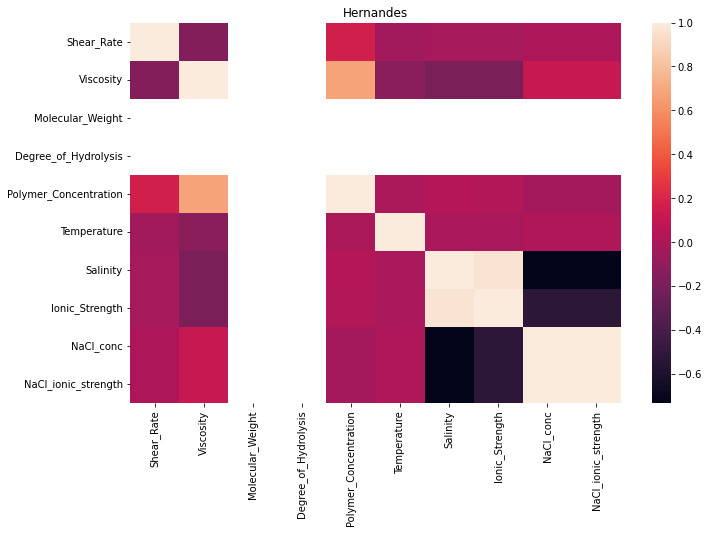

In [24]:
sns.heatmap(Hernandes.corr())
plt.title('Hernandes');

In [25]:
Hernandes.describe()

,Shear_Rate,Viscosity,Molecular_Weight,Degree_of_Hydrolysis,Polymer_Concentration,Temperature,Salinity,Ionic_Strength,NaCl_conc,NaCl_ionic_strength
count,1010.00000,1010.000000,1010.0,1.010000e+03,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,91.36774,0.019678,5000000.0,3.000000e-01,2014.653465,310.501485,7.313389,0.124386,6.225196,0.106540
std,181.43195,0.033814,0.0,5.720481e-15,1635.448229,12.505310,0.327995,0.008976,0.668878,0.011448
min,0.09621,0.000709,5000000.0,3.000000e-01,100.000000,298.150000,7.093700,0.115700,5.493200,0.094000
25%,2.91364,0.002244,5000000.0,3.000000e-01,600.000000,298.150000,7.093700,0.115700,5.493200,0.094000
50%,12.93276,0.006227,5000000.0,3.000000e-01,1500.000000,298.150000,7.093700,0.121400,6.000000,0.102700
75%,88.92608,0.019738,5000000.0,3.000000e-01,3000.000000,323.150000,7.802600,0.137300,7.093700,0.121400
max,1052.80119,0.231898,5000000.0,3.000000e-01,5000.000000,323.150000,7.802600,0.137300,7.093700,0.121400


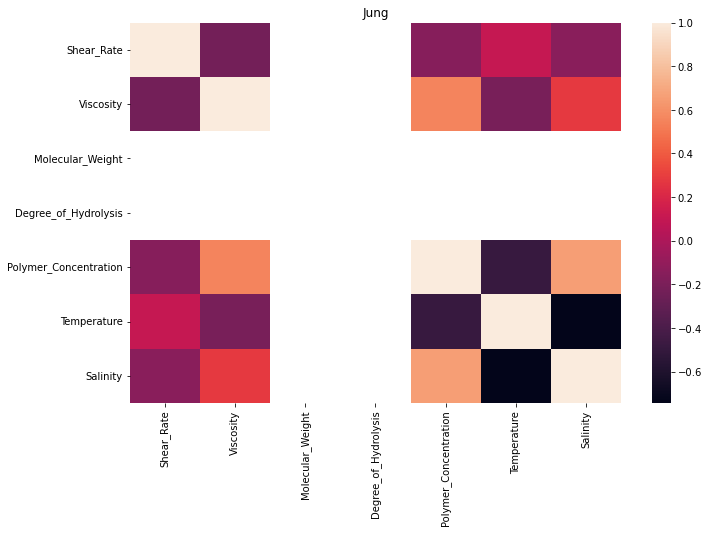

In [26]:
sns.heatmap(Jung.corr())
plt.title('Jung');

In [27]:
Jung.describe()

,Shear_Rate,Viscosity,Molecular_Weight,Degree_of_Hydrolysis,Polymer_Concentration,Temperature,Salinity
count,147.000000,147.000000,147.0,1.470000e+02,147.000000,147.000000,147.000000
mean,55.028215,0.249785,13000000.0,1.200000e-01,3452.380952,311.415306,1.775510
std,76.636512,0.730165,0.0,2.088785e-16,2478.906446,21.562692,1.479522
min,0.098511,0.002154,13000000.0,1.200000e-01,1500.000000,298.150000,0.000000
25%,4.415331,0.004962,13000000.0,1.200000e-01,1500.000000,298.150000,0.000000
50%,16.092057,0.011201,13000000.0,1.200000e-01,1500.000000,298.150000,3.000000
75%,77.709432,0.095619,13000000.0,1.200000e-01,5000.000000,323.150000,3.000000
max,284.803587,4.369121,13000000.0,1.200000e-01,8000.000000,358.150000,3.000000


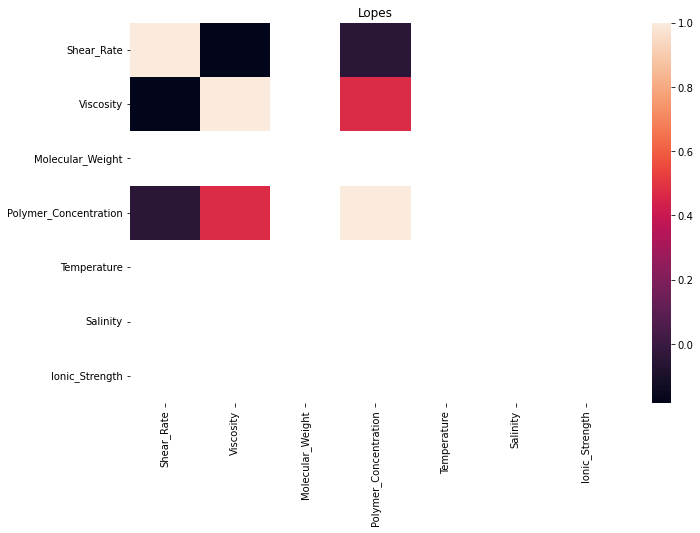

In [28]:
sns.heatmap(Lopes.corr())
plt.title('Lopes');

In [29]:
Lopes.describe()

,Shear_Rate,Viscosity,Molecular_Weight,Polymer_Concentration,Temperature,Salinity,Ionic_Strength
count,334.000000,334.000000,334.0,334.000000,3.340000e+02,334.0,334.0
mean,160.574024,0.292028,9000000.0,1045.223305,2.961500e+02,0.0,0.0
std,257.510588,0.952676,0.0,1366.122143,1.252432e-12,0.0,0.0
min,0.097654,0.001155,9000000.0,9.505000,2.961500e+02,0.0,0.0
25%,4.790848,0.003429,9000000.0,75.000000,2.961500e+02,0.0,0.0
50%,33.600000,0.019420,9000000.0,500.000000,2.961500e+02,0.0,0.0
75%,233.600000,0.117366,9000000.0,1500.000000,2.961500e+02,0.0,0.0
max,1007.944051,10.000000,9000000.0,5080.218000,2.961500e+02,0.0,0.0


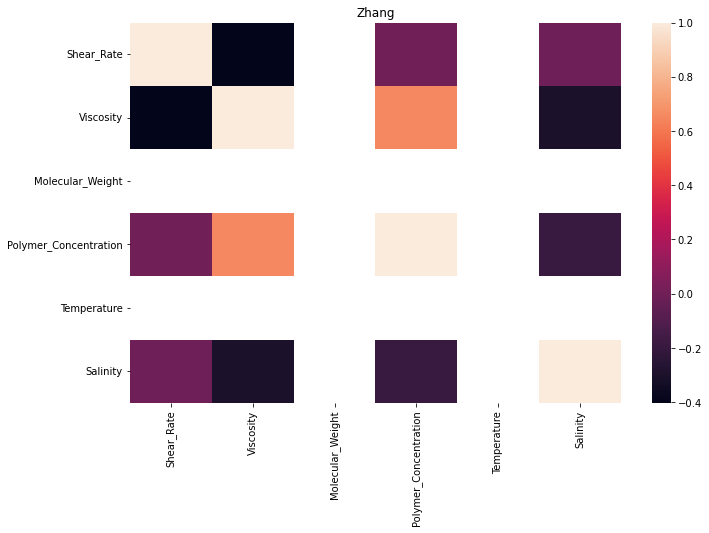

In [30]:
sns.heatmap(Zhang.corr())
plt.title('Zhang');

In [31]:
Zhang.describe()

,Shear_Rate,Viscosity,Molecular_Weight,Polymer_Concentration,Temperature,Salinity
count,406.000000,406.000000,406.0,406.000000,4.060000e+02,406.000000
mean,43.098232,0.068942,23000000.0,1322.660099,2.981500e+02,1307.389163
std,25.572904,0.076928,0.0,676.102715,2.105801e-12,2002.614237
min,5.795310,0.010530,23000000.0,600.000000,2.981500e+02,0.000000
25%,22.426900,0.022028,23000000.0,1000.000000,2.981500e+02,500.000000
50%,38.973480,0.042875,23000000.0,1000.000000,2.981500e+02,500.000000
75%,61.154295,0.084643,23000000.0,1500.000000,2.981500e+02,500.000000
max,100.711000,0.698730,23000000.0,3000.000000,2.981500e+02,6800.000000


# Cross-Validation wrt Specific Paper

Firt of all we need to specify all the columns that are in every paper. Those columns are: `['Shear_Rate', 'Viscosity', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature', 'Salinity']`

In [51]:
def pick_subset(cv_cols, target='Viscosity', dfs=[Hernandes, Jung, Lopes, Zhang]):
    df_papers = {
        'hernandes': dfs[0][cv_cols],
        'jung': dfs[1][cv_cols],
        'lopes': dfs[2][cv_cols],
        'zhang': dfs[3][cv_cols]
    }
    return df_papers

def cv_split_paper(df_papers, cv_cols, test_paper, target='Viscosity', normalize=True, poly_feat=None):
    assert test_paper in df_papers.keys()

    X_train, y_train = [], []
    X_test, y_test = [], []
    for p_name in df_papers.keys():
        if p_name == test_paper:
            x_ = df_papers[p_name].drop(columns=[target]).to_numpy()
            X_test.append(x_)
            y_test = df_papers[p_name][target].to_numpy()
        else:
            x_ = df_papers[p_name].drop(columns=[target]).to_numpy()
            y_ = df_papers[p_name][target].to_numpy()
            X_train.append(x_)
            y_train.append(y_)
            
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    
    if normalize:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    if poly_feat:
        poly_feat.fit(X_train)
        X_train = poly_feat.transform(X_train)
        X_test = poly_feat.transform(X_test)
        
    y_train = np.hstack(y_train)
    return X_train, y_train, X_test, y_test, scaler, poly_feat

def report_metrics(model, params, cv_cols,
                   names_df=['hernandes', 'jung', 'lopes', 'zhang'],
                   dfs=[Hernandes, Jung, Lopes, Zhang],
                   target='Viscosity',
                   metric='r2',
                   hyper_params=None,
                   poly_feat=None):
    assert metric in ('r2', 'mse', 'l1')
    scoring = r2_score if metric == 'r2' else mean_absolute_error if metric == 'l1' else mean_squared_error
    
    score_ls = []
    df_papers = pick_subset(cv_cols, target='Viscosity', dfs=dfs)
    for n in names_df:
        m = model
        X_train, y_train, X_test, y_test, scaler_, poly_ = cv_split_paper(df_papers, cv_cols, test_paper=n, poly_feat=poly_feat)
        
        if hyper_params:
            gr_sr = GridSearchCV(m(**params), hyper_params, cv=3, n_jobs=-1)
            gr_sr.fit(X_train, y_train)
            m = m(**params, **gr_sr.best_params_)
        else:
            m = m(**params)

        m.fit(X_train, y_train)
        y_hat_train = m.predict(X_train)
        y_hat_test = m.predict(X_test)
        
        score_train = scoring(y_train, y_hat_train)
        score_test = scoring(y_test, y_hat_test)
        score_ls.append([score_train, score_test])
    score_ls = np.vstack(score_ls)
    
    return m, scaler_, poly_, pd.DataFrame({metric+'_'+k: v for k, v in zip(['train', 'test'], score_ls.T[:])}, index=names_df)

## CV with XGBoost Regression

In [36]:
poly_feat = None

In [35]:
`cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature', 'Salinity']
params = {'random_state': 42, 'n_jobs': -1}
hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}
report_metrics(XGBRegressor, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999942,-2279.510858
jung,0.999973,-3.889084
lopes,0.999874,0.033535
zhang,0.999994,-0.630946


In [39]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature']
params = {'random_state': 42, 'n_jobs': -1}
hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}
report_metrics(XGBRegressor, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999366,-2512.544995
jung,0.999557,-3.872665
lopes,0.930532,0.003470
zhang,0.859104,-0.482914


In [40]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Polymer_Concentration', 'Temperature']
params = {'random_state': 42, 'n_jobs': -1}
hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}
report_metrics(XGBRegressor, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999445,-34.063134
jung,0.999373,0.013441
lopes,0.844621,-0.033784
zhang,0.999766,-0.498469


In [41]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Polymer_Concentration']
params = {'random_state': 42, 'n_jobs': -1}
hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}
report_metrics(XGBRegressor, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999612,-1537.999830
jung,0.382214,0.291513
lopes,0.841295,-0.048062
zhang,0.444255,-0.428793


In [42]:
cv_cols = ['Shear_Rate', 'Viscosity']
xgbr = XGBRegressor
params = {'random_state': 42, 'n_jobs': -1}
hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}
report_metrics(XGBRegressor, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.481713,-256.720800
jung,0.277652,0.096653
lopes,0.340177,0.030345
zhang,0.347352,-0.230062


## CV with Tree Regression

In [44]:
poly_feat = PolynomialFeatures(degree=2)

In [45]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature', 'Salinity']
params = {'random_state': 42}
hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 21)
}
m, scaler_, poly_, df = report_metrics(tree, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)
df

,r2_train,r2_test
hernandes,0.999975,-747.689690
jung,0.999994,0.603260
lopes,0.992848,-0.704386
zhang,0.996622,-0.628992


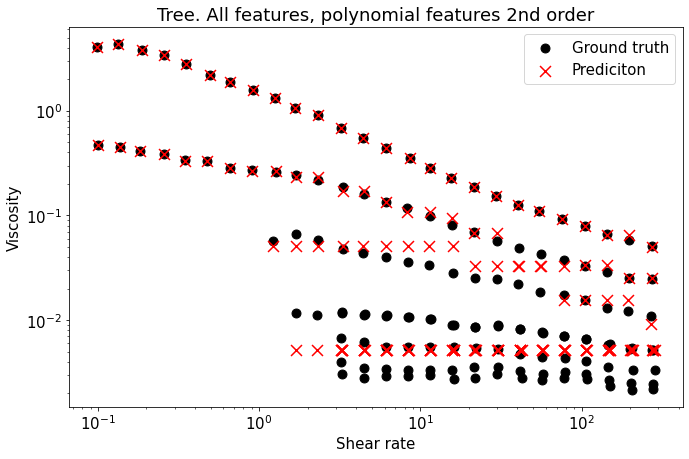

In [46]:
X_test_tree = Jung[cv_cols].drop(columns=['Viscosity'])
y_test_tree = Jung['Viscosity']
Jung_shear_rate = Jung['Shear_Rate']

X_test_tree = scaler_.transform(X_test_tree)
X_test_tree = poly_.transform(X_test_tree)

y_hat_tree = m.predict(X_test_tree)

plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["font.size"] = 15

plt.scatter(Jung_shear_rate, y_test_tree, label='Ground truth', c='k', s=80)
plt.scatter(Jung_shear_rate, y_hat_tree, label='Prediciton', c='r', marker='x', s=120)
plt.legend()
plt.xlabel('Shear rate')
plt.ylabel('Viscosity')
plt.yscale('log')
plt.xscale('log')
plt.title('Tree. All features, polynomial features 2nd order');

In [47]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature']
params = {'random_state': 42}
hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 21)
}
report_metrics(tree, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999573,-913.751971
jung,0.998722,0.228459
lopes,0.996346,-0.034315
zhang,0.998945,-0.518212


In [48]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Molecular_Weight', 'Polymer_Concentration']
params = {'random_state': 42}
hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 21)
}
report_metrics(tree, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999413,-4393.715113
jung,0.997769,-4.426686
lopes,0.995119,-0.191253
zhang,0.998790,-0.067899


In [49]:
cv_cols = ['Shear_Rate', 'Viscosity', 'Polymer_Concentration']
params = {'random_state': 42}
hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 21)
}
report_metrics(tree, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.998775,-1694.374368
jung,-0.001547,-0.052033
lopes,0.955975,-0.058785
zhang,0.169568,-0.526745


In [50]:
cv_cols = ['Shear_Rate', 'Viscosity']
params = {'random_state': 42}
hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 21)
}
report_metrics(tree, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.267284,-66.804379
jung,-0.001008,-0.068809
lopes,-0.007200,-0.071684
zhang,-0.000315,-0.680982


## CV with Ridge and Polynomial Embeddings

In [52]:
poly_feat = PolynomialFeatures(degree=3)

In [54]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature', 'Salinity']
params = {'random_state': 42}
hyper_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
report_metrics(Ridge, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.156441,-5.431450e+01
jung,0.074964,1.754048e-01
lopes,0.424367,-3.753753e-02
zhang,0.366567,-1.929013e+18


In [55]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature']
params = {'random_state': 42}
hyper_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
report_metrics(Ridge, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.153243,-51.532936
jung,0.073928,0.175766
lopes,0.423256,-0.038115
zhang,0.423280,-24915.173580


In [56]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration']
params = {'random_state': 42}
hyper_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
report_metrics(Ridge, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.149597,-60.987158
jung,0.047671,0.338534
lopes,0.418468,-0.043114
zhang,0.356151,-19695.517439


In [57]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Polymer_Concentration']
params = {'random_state': 42}
hyper_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
report_metrics(Ridge, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.234738,-108.809787
jung,0.039722,0.374411
lopes,0.404498,-0.039441
zhang,0.108075,0.090721


In [58]:
cv_cols = ['Viscosity', 'Shear_Rate']
params = {'random_state': 42}
hyper_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
report_metrics(Ridge, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.043557,-31.658428
jung,0.002075,-0.049608
lopes,0.006257,-0.058551
zhang,0.002548,-0.254528


## CV with KNNRegessor

In [60]:
poly_feat = None

In [61]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature', 'Salinity']
params = {'n_jobs': -1}
hyper_params = {
    'n_neighbors': np.arange(3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
report_metrics(knn, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,1.0,-2016.084126
jung,1.0,-3.445208
lopes,1.0,0.007496
zhang,1.0,-0.605146


In [62]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature']
params = {'n_jobs': -1}
hyper_params = {
    'n_neighbors': np.arange(3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
report_metrics(knn, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999629,-2016.083316
jung,0.999535,-3.445208
lopes,0.559680,-0.029291
zhang,0.434450,-0.468363


In [63]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration']
params = {'n_jobs': -1}
hyper_params = {
    'n_neighbors': np.arange(3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
report_metrics(knn, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999629,-2790.978704
jung,0.968320,-3.455856
lopes,0.986098,-0.053117
zhang,0.960679,-0.535145


In [64]:
cv_cols = ['Viscosity', 'Shear_Rate', 'Polymer_Concentration']
params = {'n_jobs': -1}
hyper_params = {
    'n_neighbors': np.arange(3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
report_metrics(knn, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.999656,-903.477937
jung,0.199972,0.393564
lopes,0.974879,-0.054219
zhang,0.300763,-0.373066


In [65]:
cv_cols = ['Viscosity', 'Shear_Rate']
params = {'n_jobs': -1}
hyper_params = {
    'n_neighbors': np.arange(3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
report_metrics(knn, params, cv_cols, hyper_params=hyper_params, poly_feat=poly_feat)[-1]

,r2_train,r2_test
hernandes,0.408295,-329.201159
jung,0.148974,0.108880
lopes,0.176516,-0.006840
zhang,0.164772,-0.329311


# Mix Data

In [66]:
cv_cols = ['Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration', 'Temperature', 'Salinity', 'paper', 'NaCl_only', 'Viscosity']
df_papers = pick_subset(cv_cols, target='Viscosity', dfs=[Hernandes, Jung, Lopes, Zhang])

In [67]:
data = pd.concat(df_papers.values())
data = pd.get_dummies(data, columns=['paper', 'NaCl_only'])

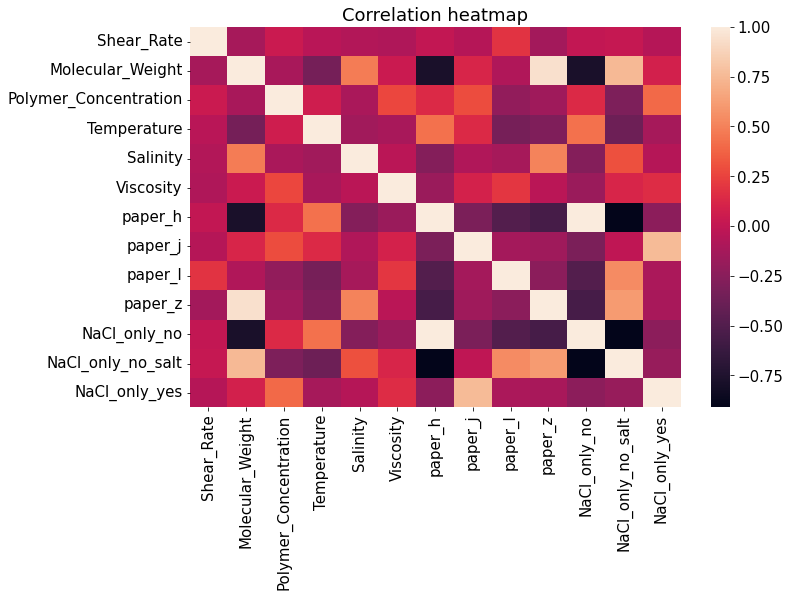

In [68]:
sns.heatmap(data.corr())
plt.title('Correlation heatmap');

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Viscosity'), data['Viscosity'],test_size=.3, random_state=42, shuffle=True)

In [72]:
data.columns

Index(['Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration',
       'Temperature', 'Salinity', 'Viscosity', 'paper_h', 'paper_j', 'paper_l',
       'paper_z', 'NaCl_only_no', 'NaCl_only_no_salt', 'NaCl_only_yes'],
      dtype='object')

In [73]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
xgbr = XGBRegressor(n_jobs=-1, random_state=42)

hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}

grid_xgbr = GridSearchCV(xgbr, hyper_params, cv=5, n_jobs=-1)
grid_xgbr.fit(X_train, y_train)

print(grid_xgbr.best_params_)

xgbr_best = XGBRegressor(**grid_xgbr.best_params_, n_jobs=-1, random_state=42)
xgbr_best.fit(X_train, y_train)
r2_score(y_train, xgbr_best.predict(X_train)), r2_score(y_test, xgbr_best.predict(X_test))

{'max_depth': 4, 'n_estimators': 190, 'reg_lambda': 0}


(0.999906994578137, 0.8473965963789309)

In [76]:
tree_reg = tree(random_state=42)

hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 31)
}

grid_tree_reg = GridSearchCV(tree_reg, hyper_params, cv=5, n_jobs=-1)
grid_tree_reg.fit(X_train, y_train)

print(grid_tree_reg.best_params_)

tree_reg = tree(**grid_tree_reg.best_params_, random_state=42)
tree_reg.fit(X_train, y_train)
y_tree_train_hat_0 = tree_reg.predict(X_train)
y_tree_test_hat_0 = tree_reg.predict(X_test)

r2_score(y_train, y_tree_train_hat_0), r2_score(y_test, y_tree_test_hat_0)

{'criterion': 'friedman_mse', 'max_depth': 21}


(0.9999999979010188, 0.8855484319373559)

### Results for Tree

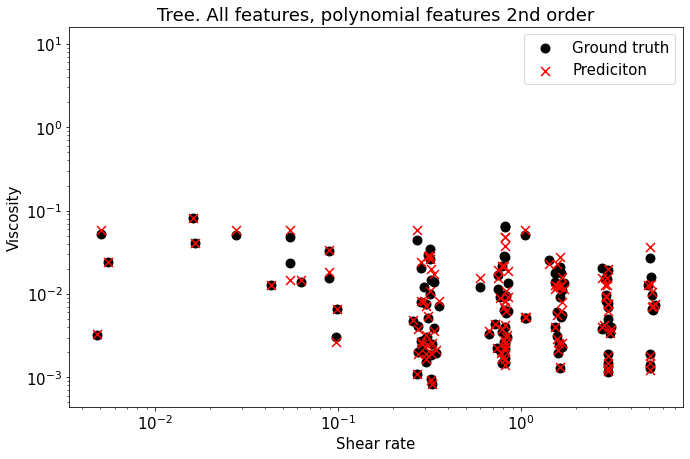

In [78]:
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["font.size"] = 15

plt.scatter(X_test[:, 0], y_test, label='Ground truth', c='k', s=80)
plt.scatter(X_test[:, 0], y_tree_test_hat_0, label='Prediciton', c='r', marker='x', s=80)
plt.legend()
plt.xlabel('Shear rate')
plt.ylabel('Viscosity')
plt.yscale('log')
plt.xscale('log')
plt.title('Tree. All features, polynomial features 2nd order');

In [79]:
knn_reg = knn(n_jobs=-1)

hyper_params = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

grid_knn_reg = GridSearchCV(knn_reg, hyper_params, cv=5, n_jobs=-1)
grid_knn_reg.fit(X_train, y_train)

print(grid_knn_reg.best_params_)

knn_reg = knn(**grid_knn_reg.best_params_, n_jobs=-1)
knn_reg.fit(X_train, y_train)
r2_score(y_train, knn_reg.predict(X_train)), r2_score(y_test, knn_reg.predict(X_test))

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


(1.0, 0.8733785377434808)

## With Polynomial Features

In [82]:
poly_ = PolynomialFeatures(degree=2)
poly_.fit(X_train)
X_train_poly = poly_.transform(X_train)
X_test_poly = poly_.transform(X_test)

In [83]:
ridge_ = Ridge(random_state=42)

hyper_params = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}

grid_ridge_ = GridSearchCV(ridge_, hyper_params, cv=5, n_jobs=-1)
grid_ridge_.fit(X_train_poly, y_train)

print(grid_ridge_.best_params_)

ridge_ = Ridge(**grid_ridge_.best_params_, random_state=42)
ridge_.fit(X_train_poly, y_train)
r2_score(y_train, ridge_.predict(X_train_poly)), r2_score(y_test, ridge_.predict(X_test_poly))

{'alpha': 1000.0}


(0.3007731245169998, 0.2317933956466125)

In [84]:
xgbr = XGBRegressor(n_jobs=-1, random_state=42)

hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}

grid_xgbr = GridSearchCV(xgbr, hyper_params, cv=5, n_jobs=-1)
grid_xgbr.fit(X_train_poly, y_train)

print(grid_xgbr.best_params_)

xgbr_best = XGBRegressor(**grid_xgbr.best_params_, n_jobs=-1, random_state=42)
xgbr_best.fit(X_train_poly, y_train)
r2_score(y_train, xgbr_best.predict(X_train_poly)), r2_score(y_test, xgbr_best.predict(X_test_poly))

{'max_depth': 3, 'n_estimators': 190, 'reg_lambda': 10.0}


(0.998903182431232, 0.9334841227714169)

In [85]:
tree_reg = tree(random_state=42)

hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 31)
}

grid_tree_reg = GridSearchCV(tree_reg, hyper_params, cv=5, n_jobs=-1)
grid_tree_reg.fit(X_train_poly, y_train)

print(grid_tree_reg.best_params_)

tree_reg = tree(**grid_tree_reg.best_params_, random_state=42)
tree_reg.fit(X_train_poly, y_train)

y_tree_train_hat = tree_reg.predict(X_train_poly)
y_tree_test_hat = tree_reg.predict(X_test_poly)

r2_score(y_train, tree_reg.predict(X_train_poly)), r2_score(y_test, tree_reg.predict(X_test_poly))

{'criterion': 'mae', 'max_depth': 18}


(0.9999944791464532, 0.9401883094251627)

### Results for Tree with Polynomial Embeddings

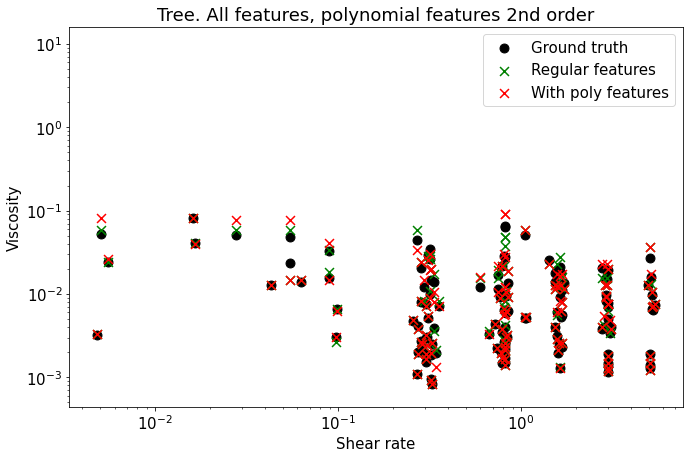

In [86]:
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["font.size"] = 15

plt.scatter(X_test[:, 0], y_test, label='Ground truth', c='k', s=80)
plt.scatter(X_test[:, 0], y_tree_test_hat_0, label='Regular features', c='g', marker='x', s=80)
plt.scatter(X_test[:, 0], y_tree_test_hat, label='With poly features', c='r', marker='x', s=80)

plt.legend()
plt.xlabel('Shear rate')
plt.ylabel('Viscosity')
plt.yscale('log')
plt.xscale('log')
plt.title('Tree. All features, polynomial features 2nd order');

In [88]:
knn_reg = knn(n_jobs=-1)

hyper_params = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

grid_knn_reg = GridSearchCV(knn_reg, hyper_params, cv=5, n_jobs=-1)
grid_knn_reg.fit(X_train_poly, y_train)

print(grid_knn_reg.best_params_)

knn_reg = knn(**grid_knn_reg.best_params_, n_jobs=-1)
knn_reg.fit(X_train_poly, y_train)
r2_score(y_train, knn_reg.predict(X_train_poly)), r2_score(y_test, knn_reg.predict(X_test_poly))

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


(1.0, 0.8733784613424496)

# Dimensionality Reduction

In [90]:
data.columns

Index(['Shear_Rate', 'Molecular_Weight', 'Polymer_Concentration',
       'Temperature', 'Salinity', 'Viscosity', 'paper_h', 'paper_j', 'paper_l',
       'paper_z', 'NaCl_only_no', 'NaCl_only_no_salt', 'NaCl_only_yes'],
      dtype='object')

In [91]:
X = data.drop(columns=['Viscosity'])
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

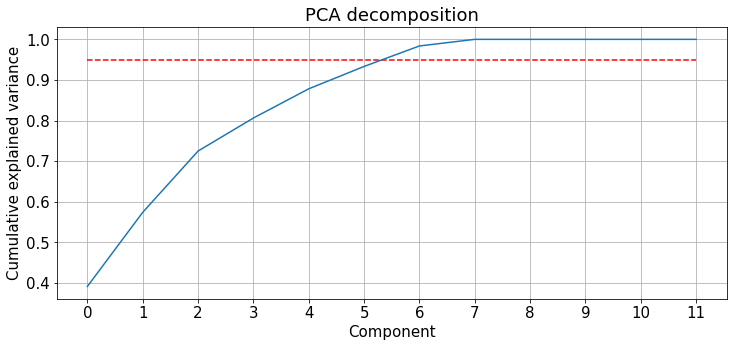

In [92]:
pca = PCA()
pca.fit(X)

plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(list(range(X.shape[1])), [0.95] * X.shape[1], '--r')
plt.plot(list(range(X.shape[1])), np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Cumulative explained variance')
plt.xlabel('Component')
plt.title('PCA decomposition')
plt.xticks(np.arange(0, 12));

In [93]:
X = data.drop(columns=['Viscosity'])
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [94]:
poly_ = PolynomialFeatures(degree=2)
poly_.fit(X)
X = poly_.transform(X)

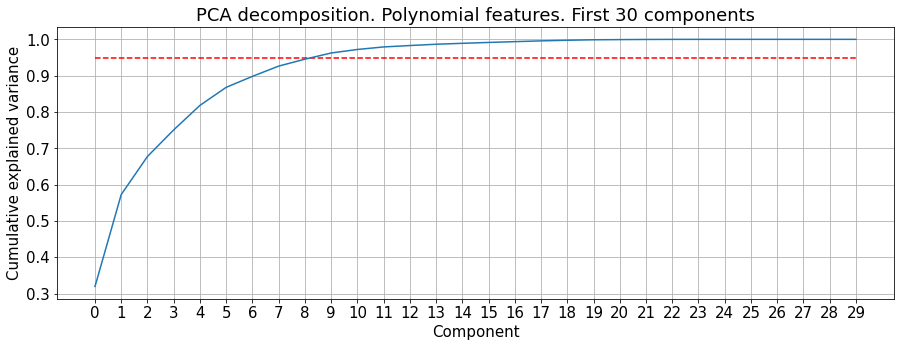

In [95]:
pca = PCA()
pca.fit(X)

plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(list(range(30)), [0.95] * 30, '--r')
plt.plot(list(range(30)), np.cumsum(pca.explained_variance_ratio_)[:30]);
plt.grid()
plt.ylabel('Cumulative explained variance')
plt.xlabel('Component')
plt.title('PCA decomposition. Polynomial features. First 30 components')
plt.xticks(ticks=np.arange(0, 30));

### PCA on regular features

In [96]:
X = data.drop(columns='Viscosity')
y = data['Viscosity']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA(n_components=5)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, shuffle=True)

In [97]:
xgbr = XGBRegressor(n_jobs=-1, random_state=42)

hyper_params = {
    'n_estimators': np.arange(50, 201, 20),
    'max_depth': np.arange(3, 18),
    'reg_lambda': [1e-2, 1e-1, 0, 1e1, 1e2]
}

grid_xgbr = GridSearchCV(xgbr, hyper_params, cv=5, n_jobs=-1)
grid_xgbr.fit(X_train, y_train)

print(grid_xgbr.best_params_)

xgbr_best = XGBRegressor(**grid_xgbr.best_params_, n_jobs=-1, random_state=42)
xgbr_best.fit(X_train, y_train)
r2_score(y_train, xgbr_best.predict(X_train)), r2_score(y_test, xgbr_best.predict(X_test))

{'max_depth': 6, 'n_estimators': 70, 'reg_lambda': 0.01}


(0.9999418951324749, 0.8636067243499821)

In [99]:
tree_reg = tree(random_state=42)

hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 31)
}

grid_tree_reg = GridSearchCV(tree_reg, hyper_params, cv=5, n_jobs=-1)
grid_tree_reg.fit(X_train, y_train)

print(grid_tree_reg.best_params_)

tree_reg = tree(**grid_tree_reg.best_params_, random_state=42)
tree_reg.fit(X_train, y_train)
r2_score(y_train, tree_reg.predict(X_train)), r2_score(y_test, tree_reg.predict(X_test))

{'criterion': 'mae', 'max_depth': 17}


(0.9999867872612982, 0.8734971621577757)

In [100]:
knn_reg = knn(n_jobs=-1)

hyper_params = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

grid_knn_reg = GridSearchCV(knn_reg, hyper_params, cv=5, n_jobs=-1)
grid_knn_reg.fit(X_train, y_train)

print(grid_knn_reg.best_params_)

knn_reg = knn(**grid_knn_reg.best_params_, n_jobs=-1)
knn_reg.fit(X_train, y_train)
r2_score(y_train, knn_reg.predict(X_train)), r2_score(y_test, knn_reg.predict(X_test))

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


(1.0, 0.873364188683337)

### PCA on polynomial features

In [101]:
X = data.drop(columns='Viscosity')
y = data['Viscosity']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

poly_ = PolynomialFeatures(degree=2)
poly_.fit(X)
X = poly_.transform(X)

pca = PCA(n_components=8)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, shuffle=True)

In [102]:
tree_reg = tree(random_state=42)

hyper_params = {
    'criterion': ["mse", "friedman_mse", "mae", "poisson"],
    'max_depth': np.arange(2, 31)
}

grid_tree_reg = GridSearchCV(tree_reg, hyper_params, cv=5, n_jobs=-1)
grid_tree_reg.fit(X_train, y_train)

print(grid_tree_reg.best_params_)

tree_reg = tree(**grid_tree_reg.best_params_, random_state=42)
tree_reg.fit(X_train, y_train)
r2_score(y_train, tree_reg.predict(X_train)), r2_score(y_test, tree_reg.predict(X_test))

{'criterion': 'friedman_mse', 'max_depth': 18}


(0.999998144922406, 0.8604335947941473)

In [103]:
knn_reg = knn(n_jobs=-1)

hyper_params = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

grid_knn_reg = GridSearchCV(knn_reg, hyper_params, cv=5, n_jobs=-1)
grid_knn_reg.fit(X_train, y_train)

print(grid_knn_reg.best_params_)

knn_reg = knn(**grid_knn_reg.best_params_, n_jobs=-1)
knn_reg.fit(X_train, y_train)
r2_score(y_train, knn_reg.predict(X_train)), r2_score(y_test, knn_reg.predict(X_test))

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


(1.0, 0.8733829831802002)